# Creating our own Image Classifier using Amazon Sagemaker

This is the hands-on Jupyter notebook of the article with the same name, published on the AWS AI Blog. The idea here is to show you how to create an end-to-end Image Classifcation solution, using Amazon Sagemaker. We will use here a technique called Transfer Learning, detailed in the blog post. We will pick a pre-trained Resnet152 (Imagenet11K) and specialize it to classify 10 different pieces of clothing and accessories.

This hands on is comprised in four parts:

   1. [Preparing your dataset](#Preparing-your-dataset)
       1. [Download the files (idx format)](#Let's-start-by-downloading-the-Fashin-MNIST-dataset)
       1. [Extract all the images](#Now-let's-create-a-directories-structure-for-our-images)
       1. [Create the RecordIO .lst files](#Creating-the-RecordIO-list-files)
       1. [Create the RecordIO .rec files](#Then,-using-the-.lst-files,-let's-create-both-RecordIO-files-%28train-and-test%29)
       1. [Upload the prepared dataset to S3](#Good.-Now,-let's-upload-the-.rec-files-to-S3)
   2. [Setup your Environment](#Setup-your-Environment)
   3. [Create your model](#Create-your-model)
       3. Train your model
       3. Pack your model
       3. Create an Endpoint Configuration
       3. Deploy your model
   4. [Test your model](#Test-your-model)

----    
This notebooks is based on the original Amazon Sagemaker sample notebook: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning.ipynb

## Preparing your dataset
For this experiment we will use a famous public dataset called Fashion MNIST. So, the outcome of this process is a trained model capable of classifying all the categories from this dataset.

### Fashion MNIST
Fashion-MNIST is a dataset of Zalando’s article, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

#### CLASSES


  1. T-shirt/top
  2. Trouser
  3. Pullover
  4. Dress
  5. Coat
  6. Sandal
  7. Shirt
  8. Sneaker
  9. Bag
  10. Ankle boot

#### References

https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/

https://github.com/zalandoresearch/fashion-mnist/

### Let's start by downloading the Fashin MNIST dataset
Please notice that it is in **idx** format. So, we need to extract all the images from it.

In [52]:
base_dir='/tmp/fashion'
dataset_dir='https://workshopml.spock.cloud/datasets/fashion-mnist'
pre_trained_model='https://workshopml.spock.cloud/models/fashion-mnist/model.tar.gz'

In [2]:
!mkdir -p $base_dir/samples
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz | gunzip > $base_dir/samples/train-images-idx3-ubyte
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz | gunzip > $base_dir/samples/train-labels-idx1-ubyte
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz | gunzip > $base_dir/samples/t10k-images-idx3-ubyte
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz | gunzip > $base_dir/samples/t10k-labels-idx1-ubyte
!ls -lat $base_dir/samples/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  5160k      0  0:00:05  0:00:05 --:--:-- 6176k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0  29515      0  0:00:01 --:--:--  0:00:01 93401
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  1439k      0  0:00:03  0:00:03 --:--:-- 1379k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0   5148      0  0:00:01 --:--:--  0:00:01 23085
total 53680
-rw-rw-r-- 1 ec2-user ec2-user    10008 

### Now let's create a directories structure for our images
All the images of a particular class will be stored in its respective directory. Since Fashin MNIST has 10 distinct classes, we'll have 10 different directories, one for each class.
  
**DIRECTORY STRUCTURE**
  - ./fashion_mnist/
      - TShirtTop/image1.jpg
      - TShirtTop/image2.jpg
      - Trouser/image100.jpg
      - ..
      - AnkleBoot/imageN.jpg

In [3]:
!mkdir -p $base_dir/fashion_mnist

import os
categories = ['TShirtTop', 'Trouser', 'Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','AnkleBoot' ]

for i in categories:
    try:
        os.mkdir(base_dir + '/fashion_mnist/%s' % i)
    except OSError as e:
        print(e)

### Then, let's unpack the dataset to the directories

In [4]:
!pip install python-mnist
from mnist import MNIST
from PIL import Image
import numpy as np

mndata = MNIST(base_dir + '/samples')
counter = 0
images, labels = mndata.load_training()
for i, img in enumerate(images):
    img = np.reshape(img, (28, 28))
    img = Image.fromarray(np.uint8(np.array(img)))
    img = img.convert("RGB")
    img.save(base_dir + '/fashion_mnist/%s/img_%d.jpg' % (categories[labels[i]], counter ))
    counter += 1

images, labels = mndata.load_testing()
for i, img in enumerate(images):
    img = np.reshape(img, (28, 28))
    img = Image.fromarray(np.uint8(np.array(img)))
    img = img.convert("RGB")
    img.save(base_dir + '/fashion_mnist/%s/img_%d.jpg' % (categories[labels[i]], counter ))
    counter += 1

!ls -lat $base_dir/fashion_mnist/

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
total 2528
drwxrwxr-x  2 ec2-user ec2-user 245760 Mar 27 00:17 AnkleBoot
drwxrwxr-x  2 ec2-user ec2-user 253952 Mar 27 00:17 Bag
drwxrwxr-x  2 ec2-user ec2-user 253952 Mar 27 00:17 Sandal
drwxrwxr-x  2 ec2-user ec2-user 249856 Mar 27 00:17 Trouser
drwxrwxr-x  2 ec2-user ec2-user 258048 Mar 27 00:17 Coat
drwxrwxr-x  2 ec2-user ec2-user 249856 Mar 27 00:17 Dress
drwxrwxr-x  2 ec2-user ec2-user 249856 Mar 27 00:17 Pullover
drwxrwxr-x  2 ec2-user ec2-user 258048 Mar 27 00:17 Shirt
drwxrwxr-x  2 ec2-user ec2-user 266240 Mar 27 00:17 Sneaker
drwxrwxr-x  2 ec2-user ec2-user 253952 Mar 27 00:17 TShirtTop
drwxrwxr-x 12 ec2-user ec2-user   4096 Mar 27 00:17 .
drwxrwxr-x  4 ec2-user ec2-user   4096 Mar 27 00:17 ..


### Creating the RecordIO list files
Right, now that we have all the images in their respective directories, one per class, it is time to create the RecordIO file. RecordIO is a optimized file format that will feed our images to the Neural Network during training.

We will split the dataset into training (70%) and testing (30%). To do that, we'll run a python script (im2rec), which is the best tool for this job.

In [5]:
# Here we will search for the python script im2rec
import sys,os

suffix='/mxnet/tools/im2rec.py'
im2rec = list(filter( (lambda x: os.path.isfile(x + suffix )), sys.path))[0] + suffix
%env IM2REC=$im2rec
%env BASE_DIR=$base_dir

env: IM2REC=/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/tools/im2rec.py
env: BASE_DIR=/tmp/fashion


In [6]:
%%bash

cd $BASE_DIR
python $IM2REC --list=1 --recursive=1 --shuffle=1 --test-ratio=0.3 --train-ratio=0.7 fashion_mnist fashion_mnist/
ls *.lst

AnkleBoot 0
Bag 1
Coat 2
Dress 3
Pullover 4
Sandal 5
Shirt 6
Sneaker 7
TShirtTop 8
Trouser 9
fashion_mnist_test.lst
fashion_mnist_train.lst


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


###  Then, using the .lst files, let's create both RecordIO files (train and test)

In [7]:
%%bash 

cd $BASE_DIR
python $IM2REC --num-thread=4 --pass-through=1 fashion_mnist_train.lst fashion_mnist
python $IM2REC --num-thread=4 --pass-through=1 fashion_mnist_test.lst fashion_mnist
ls *.rec

Creating .rec file from /tmp/fashion/fashion_mnist_train.lst in /tmp/fashion
time: 0.011396408081054688  count: 0
time: 0.07727336883544922  count: 1000
time: 0.04679679870605469  count: 2000
time: 0.08986759185791016  count: 3000
time: 0.06664443016052246  count: 4000
time: 0.047377824783325195  count: 5000
time: 0.07457399368286133  count: 6000
time: 0.05047035217285156  count: 7000
time: 0.05344891548156738  count: 8000
time: 0.07363200187683105  count: 9000
time: 0.05623269081115723  count: 10000
time: 0.0759420394897461  count: 11000
time: 0.04192066192626953  count: 12000
time: 0.03501105308532715  count: 13000
time: 0.044275522232055664  count: 14000
time: 0.05683636665344238  count: 15000
time: 0.05958271026611328  count: 16000
time: 0.06450319290161133  count: 17000
time: 0.04107356071472168  count: 18000
time: 0.05511164665222168  count: 19000
time: 0.08146357536315918  count: 20000
time: 0.03206133842468262  count: 21000
time: 0.03871870040893555  count: 22000
time: 0.076876

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### Good. Now, let's upload the .rec files to S3

In [8]:
import sagemaker

# Get the current Sagemaker session
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

In [9]:
train_path = sagemaker_session.upload_data(path=base_dir + '/fashion_mnist_train.rec', key_prefix='fashion_mnist/train')
test_path = sagemaker_session.upload_data(path=base_dir + '/fashion_mnist_test.rec', key_prefix='fashion_mnist/test')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862


## Setup your Environment

Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

   1. The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
   2. The S3 bucket that you want to use for training and model data
   3. The Amazon sagemaker image classification docker image which need not be changed

In [10]:
%%time
import boto3
import re
import os
import time

from time import gmtime, strftime
from sagemaker import get_execution_role

# 1. Obtaining the role you already configured for Sagemaker when you setup
# your Instance notebook (https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)
role = get_execution_role()

# 2. The S3 Bucket that will store the dataset and the trained model
# It was already defined above, while we uploaded the RecordIO files to the S3 bucket.

# 3. Select the correct Docker image with the Image Classification algorithm
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 58 ms


### Here you can find the hyperparameters. These parameters will determine how your model will be trained and, consequently, how your trained model will behave.

In [11]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 152 layers
num_layers = 152
# we need to specify the input image shape for the training data
image_shape = "3,28,28"
# we also need to specify the number of training samples in the training set
# for fashion_mnist it is 70012
num_training_samples = 70012
# specify the number of output classes
num_classes = 10
# batch size for training
mini_batch_size = 1024
# number of epochs
epochs = 1
# learning rate
learning_rate = 0.00001
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1
# Training algorithm/optimizer. Default is SGD
optimizer = 'sgd'

### Using all the parameters and hyperparameters we just defined, let's wrap up in an structure for Sagemaker to start a job for us

In [12]:
dataset_prefix='fashion_mnist'
# create unique job name 
job_name_prefix = 'fashion-mnist'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp

training_params = {}

# Here we set the reference for the Image Classification Docker image, stored on ECR (https://aws.amazon.com/pt/ecr/)
training_params["AlgorithmSpecification"] = {
    "TrainingImage": training_image,
    "TrainingInputMode": "File"
}

# The IAM role with all the permissions given to Sagemaker
training_params["RoleArn"] = role

# Here Sagemaker will store the final trained model
training_params["OutputDataConfig"] = {
    "S3OutputPath": 's3://{}/{}/output'.format(sagemaker_session.default_bucket(), job_name_prefix)
}

# This is the config of the instance that will execute the training
training_params["ResourceConfig"] = {
    "InstanceCount": 1,
    "InstanceType": "ml.p2.xlarge",
    "VolumeSizeInGB": 50
}

# The job name. You'll see this name in the Jobs section of the Sagemaker's console
training_params["TrainingJobName"] = job_name

# Here you will configure the hyperparameters used for training your model.
training_params["HyperParameters"] = {
    "image_shape": image_shape,
    "num_layers": str(num_layers),
    "num_training_samples": str(num_training_samples),
    "num_classes": str(num_classes),
    "mini_batch_size": str(mini_batch_size),
    "epochs": str(epochs),
    "learning_rate": str(learning_rate),
    "use_pretrained_model": str(use_pretrained_model),
    "optimizer": optimizer
}

# Training timeout
training_params["StoppingCondition"] = {
    "MaxRuntimeInSeconds": 360000
}

# The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
training_params["InputDataConfig"] = []

# Please notice that we're using application/x-recordio for both 
# training and validation datasets, given our dataset is formated in RecordIO

# Here we set training dataset
# Training data should be inside a subdirectory called "train"
training_params["InputDataConfig"].append({
    "ChannelName": "train",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": train_path,
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "application/x-recordio",
    "CompressionType": "None"
})

# Here we set validation dataset
# Validation data should be inside a subdirectory called "validation"
training_params["InputDataConfig"].append({
    "ChannelName": "validation",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": test_path,
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "application/x-recordio",
    "CompressionType": "None"
})

print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: fashion-mnist-2018-03-27-00-19-15

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-715445047862/fashion_mnist/train/fashion_mnist_train.rec', 'S3DataDistributionType': 'FullyReplicated'}


## Create your model
You'll create your model in four steps:
  1. First you'll submit a job for sagemaker to train your model using your dataset uploaded to S3
  2. Second you'll pack the job output into model ready to be used
  3. Then you'll create an Endpoint Configuration, which is the metadata used by Sagemaker to deploy your model
  4. Finally you'll deploy your model using the Endpoint Configuration

In [13]:
# Get the Sagemaker client
sagemaker = boto3.client(service_name='sagemaker')

### Part 1/4 - Train your model (you can skip this session)
Here we will submit a job, described by the training parameters defined above, for training your model

In [56]:
# create the Amazon SageMaker training job

sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('TrainingJob_Created').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


### Part 2/4 - Pack your model
Ok. It is time to convert the job output into a model.
After running the commend bellow it will appear on the Model section of your Sagemaker console

In [14]:
# If you skip the last session, keep this variable=True, False otherwise
use_pretrained_model=True

In [40]:
%%time
import boto3
from time import gmtime, strftime

model_name="fashion-mnist"
print(model_name)
if use_pretrained_model:
    default_bucket=sagemaker_session.default_bucket()
    prefix="fashion-mnist/model/model.tar.gz"
    model_data="s3://{}/{}".format(default_bucket, prefix)
    s3 = boto3.client('s3')
    resp = s3.list_objects(Bucket=default_bucket, Prefix=prefix)
    if resp.get("Contents") is None:
        print("Please wait. It will take around 6mins")
        !curl -s $pre_trained_model | aws s3 cp - s3://$default_bucket/fashion-mnist/model/model.tar.gz
else:
    info = sagemaker.describe_training_job(TrainingJobName=job_name)
    model_data = info['ModelArtifacts']['S3ModelArtifacts']
    print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

fashion-mnist-lab
CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 231 ms


### Part 3/4 Create an Endpoint Config for your model
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [41]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.c4.2xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: fashion-mnist-epc--2018-03-27-00-37-11
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:715445047862:endpoint-config/fashion-mnist-epc--2018-03-27-00-37-11


### Part 4/4 - Deploy your model

Lastly, you will create the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [42]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))


# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('Endpoint_Created').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Endpoint name: fashion-mnist-ep--2018-03-27-00-37-26
EndpointArn = arn:aws:sagemaker:us-east-1:715445047862:endpoint/fashion-mnist-ep--2018-03-27-00-37-26
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService
CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 12min 2s


## Test your model

Let's recapitulate. We've just trained an Image Classifier model using Fashion MNIST. What does that mean? It means that now, we have an 'WebService' accessible by the endpoint we just deployed, that has the power to classify 10 different types of objects: 1) Ankle Boot; 2) Bag; 3) Coat; 4) Dress; 5) Pullover; 6) Sandal; 7) Shirt; 8) Sneaker; 9) TShirt 10) Trouser.

With that in mind let's test our model in real clothes pictures and see what happens.

In **test_data** directory you will find 5 images of 5 real itens as you can see bellow.

In [53]:
# Download test data
import mxnet as mx

!mkdir -p $base_dir/test_data
for i in range(5):
    mx.test_utils.download(dataset_dir + '/test_data/item%d_thumb.jpg' % (i+1), dirname=base_dir + '/test_data'),

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image

test_categories = ['Shirt','TShirtTop', 'AnkleBoot', 'Sneaker', 'Bag']

f, axarr = plt.subplots(1, 5, figsize=(20,12))
col = 0
for i in range(5):
    im = Image.open(base_dir + '/test_data/item%d_thumb.jpg' % (i+1))
    axarr[col].text(0, 0, '%s' %(test_categories[i] ), fontsize=15, color='blue')
    frame = axarr[col].imshow(im)
    col += 1
plt.show()

### And finally, let's do some predictions with the images above! :)

Shirt (0.794700)
TShirtTop (0.999502)
AnkleBoot (0.999889)
Sneaker (0.999952)
Bag (0.795328)


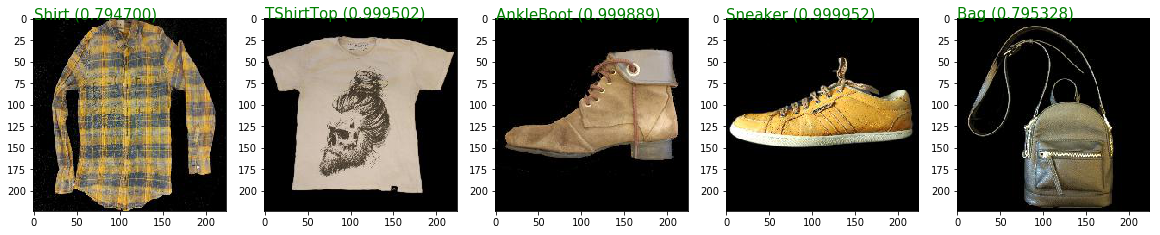

In [27]:
import json
import numpy as np
from io import BytesIO

runtime = boto3.Session().client(service_name='sagemaker-runtime') 
object_categories = ['AnkleBoot','Bag','Coat','Dress','Pullover','Sandal','Shirt','Sneaker','TShirtTop','Trouser']

_, axarr = plt.subplots(1, 5, figsize=(20,12))
col = 0
for i in range(5):
    
    # Load the image bytes
    img = open(base_dir + '/test_data/item%d_thumb.jpg' % (i+1), 'rb').read()
    
    # Call your model for predicting which object appears in this image.
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType='application/x-image', 
        Body=bytearray(img)
    )
    # read the prediction result and parse the json
    result = response['Body'].read()
    result = json.loads(result)
    
    # which category has the highest confidence?
    pred_label_id = np.argmax(result)
    
    # Green when our model predicted correctly, otherwise, Red
    text_color = 'red'
    if object_categories[pred_label_id] == test_categories[i]:
        text_color = 'green'

    # Render the text for each image/prediction
    output_text = '%s (%f)' %(object_categories[pred_label_id], result[pred_label_id] )
    axarr[col].text(0, 0, output_text, fontsize=15, color=text_color)
    print( output_text )
    
    # Render the image
    img = Image.open(BytesIO(img))
    frame = axarr[col].imshow(img)
    
    col += 1
plt.show()

### Yay! We made it! Now, it is time to you prepare your own dataset and create your Custom Image Classifier

## Clean up
When we're done with the endpoint, we can just delete it and the backing instances will be released. Run the following cell to delete the endpoint.

In [68]:
sagemaker.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '0',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 23 Feb 2018 17:51:50 GMT',
   'x-amzn-requestid': '5adfa687-d09a-4c5e-b342-60189062fc56'},
  'HTTPStatusCode': 200,
  'RequestId': '5adfa687-d09a-4c5e-b342-60189062fc56',
  'RetryAttempts': 0}}